# DLS Reading Python Code
## last edit by Alison 8/1/2023

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import re

#from google.colab import drive
#drive.mount('/content/drive')

# Load Data

In [2]:
df = pd.read_excel('/Users/alison/Library/CloudStorage/GoogleDrive-alui@berkeley.edu/My Drive/Research/AL Data/B3P170 - R18 and CF LUV + LNP/2023-07-27 - DLS/2023-07-27 lnp.xlsx')
df.head(2)

,Measurement Date and Time,Record Number,Sample Name,Intensities[1] (Percent),Intensities[2] (Percent),Intensities[3] (Percent),Intensities[4] (Percent),Intensities[5] (Percent),Intensities[6] (Percent),Intensities[7] (Percent),...,Numbers[62] (Percent),Numbers[63] (Percent),Numbers[64] (Percent),Numbers[65] (Percent),Numbers[66] (Percent),Numbers[67] (Percent),Numbers[68] (Percent),Numbers[69] (Percent),Numbers[70] (Percent),Diffusion Coefficient (µ²/s)
0,"Thursday, July 27, 2023 8:42:10 PM",1,306oi10 LNP pH 7.4 0.1X 1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.69
1,"Thursday, July 27, 2023 8:44:43 PM",2,306oi10 LNP pH 7.4 0.1X 2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.78


# Extract Size Data in nm

In [3]:
size = df.filter(regex=r'Size').drop_duplicates().T.reset_index().rename(columns={0:"Diameter (nm)"})
size['DLS index'] = size['index'].str.findall(r'\d+').explode()
size = size.drop(columns='index')
size.head(2)

,Diameter (nm),DLS index
0,0.4000,1
1,0.4632,2


# Format sample names

In [4]:
info = pd.DataFrame(df.loc[:,['Measurement Date and Time','Sample Name']].copy(deep=True))
info['Triplicate'] = info['Sample Name'].str.strip().str[-1]
info['title'] = info['Sample Name'].str.rstrip(r'123 ')
info.head()

,Measurement Date and Time,Sample Name,Triplicate,title
0,"Thursday, July 27, 2023 8:42:10 PM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X
1,"Thursday, July 27, 2023 8:44:43 PM",306oi10 LNP pH 7.4 0.1X 2,2,306oi10 LNP pH 7.4 0.1X
2,"Thursday, July 27, 2023 8:47:16 PM",306oi10 LNP pH 7.4 0.1X 3,3,306oi10 LNP pH 7.4 0.1X
3,"Friday, July 28, 2023 6:32:18 PM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X
4,"Friday, July 28, 2023 6:34:41 PM",306oi10 LNP pH 7.4 0.1X 2,2,306oi10 LNP pH 7.4 0.1X


# Format date and time 

In [5]:
info = info.join(pd.DataFrame(info["Measurement Date and Time"].str.findall(r'([A-Z][a-z]*), ([A-Z][a-z]*) (\d\d?), (\d{4}) (\d\d?:\d\d?:\d\d [AP]M)').explode().to_list(), columns=["day of week","month","day","year","time"]))
info.head()

,Measurement Date and Time,Sample Name,Triplicate,title,day of week,month,day,year,time
0,"Thursday, July 27, 2023 8:42:10 PM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X,Thursday,July,27,2023,8:42:10 PM
1,"Thursday, July 27, 2023 8:44:43 PM",306oi10 LNP pH 7.4 0.1X 2,2,306oi10 LNP pH 7.4 0.1X,Thursday,July,27,2023,8:44:43 PM
2,"Thursday, July 27, 2023 8:47:16 PM",306oi10 LNP pH 7.4 0.1X 3,3,306oi10 LNP pH 7.4 0.1X,Thursday,July,27,2023,8:47:16 PM
3,"Friday, July 28, 2023 6:32:18 PM",306oi10 LNP pH 7.4 0.1X 1,1,306oi10 LNP pH 7.4 0.1X,Friday,July,28,2023,6:32:18 PM
4,"Friday, July 28, 2023 6:34:41 PM",306oi10 LNP pH 7.4 0.1X 2,2,306oi10 LNP pH 7.4 0.1X,Friday,July,28,2023,6:34:41 PM


# Find all unique titles and dates

In [6]:
samples = info.loc[:,["title","day of week","month","day","year"]].drop_duplicates()

In [7]:
samples["id"] = np.arange(0,samples.shape[0])
samples

,title,day of week,month,day,year,id
0,306oi10 LNP pH 7.4 0.1X,Thursday,July,27,2023,0
3,306oi10 LNP pH 7.4 0.1X,Friday,July,28,2023,1
6,306oi10 LNP pH 7.4 0.1X,Monday,July,31,2023,2
9,CF POPG LUV 1X,Monday,July,31,2023,3
12,CF POPC LUV 1X,Monday,July,31,2023,4
15,R18 POPC LUV pH 7.4 0.025X,Monday,July,31,2023,5
18,R18 POPG LUV pH 7.4 0.025X,Monday,July,31,2023,6


In [8]:
info = info.merge(samples, 
           left_on=["title","day of week","month","day","year"],
           right_on=["title","day of week","month","day","year"]
          )

# Create intensity dataframe

In [9]:
intensity = df.filter(regex=r'Sample Name|Intensities').set_index('Sample Name').T
intensity['DLS index'] = pd.Series(intensity.index).str.findall(r'\d+').explode().values
intensity.head(2)

Sample Name,306oi10 LNP pH 7.4 0.1X 1,306oi10 LNP pH 7.4 0.1X 2,306oi10 LNP pH 7.4 0.1X 3,306oi10 LNP pH 7.4 0.1X 1,306oi10 LNP pH 7.4 0.1X 2,306oi10 LNP pH 7.4 0.1X 3,306oi10 LNP pH 7.4 0.1X 1,306oi10 LNP pH 7.4 0.1X 2,306oi10 LNP pH 7.4 0.1X 3,CF POPG LUV 1X 1,...,CF POPC LUV 1X 1,CF POPC LUV 1X 2,CF POPC LUV 1X 3,R18 POPC LUV pH 7.4 0.025X 1,R18 POPC LUV pH 7.4 0.025X 2,R18 POPC LUV pH 7.4 0.025X 3,R18 POPG LUV pH 7.4 0.025X 1,R18 POPG LUV pH 7.4 0.025X 2,R18 POPG LUV pH 7.4 0.025X 3,DLS index
Intensities[1] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Intensities[2] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


## Join to "df_main"

In [10]:
df_main = intensity.melt(id_vars='DLS index', value_vars=intensity.columns, value_name='Intensity %')
df_main.head(2)

,DLS index,Sample Name,Intensity %
0,1,306oi10 LNP pH 7.4 0.1X 1,0.0
1,2,306oi10 LNP pH 7.4 0.1X 1,0.0


# Create number dataframe

In [11]:
number = df.filter(regex=r'Sample Name|Numbers').set_index('Sample Name').T
number['DLS index'] = pd.Series(number.index).str.findall(r'\d+').explode().values
number.head(2)

Sample Name,306oi10 LNP pH 7.4 0.1X 1,306oi10 LNP pH 7.4 0.1X 2,306oi10 LNP pH 7.4 0.1X 3,306oi10 LNP pH 7.4 0.1X 1,306oi10 LNP pH 7.4 0.1X 2,306oi10 LNP pH 7.4 0.1X 3,306oi10 LNP pH 7.4 0.1X 1,306oi10 LNP pH 7.4 0.1X 2,306oi10 LNP pH 7.4 0.1X 3,CF POPG LUV 1X 1,...,CF POPC LUV 1X 1,CF POPC LUV 1X 2,CF POPC LUV 1X 3,R18 POPC LUV pH 7.4 0.025X 1,R18 POPC LUV pH 7.4 0.025X 2,R18 POPC LUV pH 7.4 0.025X 3,R18 POPG LUV pH 7.4 0.025X 1,R18 POPG LUV pH 7.4 0.025X 2,R18 POPG LUV pH 7.4 0.025X 3,DLS index
Numbers[1] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Numbers[2] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


## Join to "df_main"

In [12]:
df_main = df_main.merge(number.melt(id_vars='DLS index', value_vars=number.columns, value_name='Number %'))
df_main.head(2)

,DLS index,Sample Name,Intensity %,Number %
0,1,306oi10 LNP pH 7.4 0.1X 1,0.0,0.0
1,1,306oi10 LNP pH 7.4 0.1X 1,0.0,0.0


# Merge in 'Size' and 'Info'

In [13]:
df_main = df_main.merge(size).merge(info)
df_main.head(2)

,DLS index,Sample Name,Intensity %,Number %,Diameter (nm),Measurement Date and Time,Triplicate,title,day of week,month,day,year,time,id
0,1,306oi10 LNP pH 7.4 0.1X 1,0.0,0.0,0.4,"Thursday, July 27, 2023 8:42:10 PM",1,306oi10 LNP pH 7.4 0.1X,Thursday,July,27,2023,8:42:10 PM,0
1,1,306oi10 LNP pH 7.4 0.1X 1,0.0,0.0,0.4,"Friday, July 28, 2023 6:32:18 PM",1,306oi10 LNP pH 7.4 0.1X,Friday,July,28,2023,6:32:18 PM,1


# Plot DLS Data

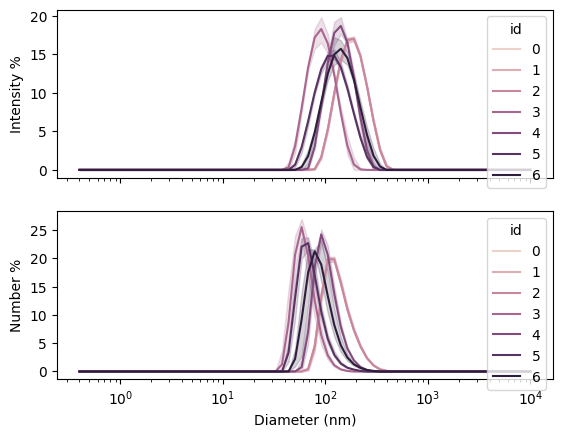

In [14]:
fig, ax = plt.subplots(2,1, sharex=True)

sns.lineplot(data=df_main,
             x="Diameter (nm)",
             y="Intensity %",
             hue="id",
             ax=ax[0])

sns.lineplot(data=df_main,
             x="Diameter (nm)",
             y="Number %",
             hue="id",
             ax=ax[1])

ax[0].set_xscale('log')

# Compute mean and mode

In [15]:
df_pivot = pd.pivot_table(data=df_main,
               index="id",
               values = ["Intensity %","Number %"],
               aggfunc = ["max"])
df_pivot.head()

max         
   Intensity % Number %
id                     
0         17.9     21.2
1         17.9     21.2
2         17.9     21.2
3         19.8     27.0
4         19.8     25.1

In [16]:
for i in df_pivot.index:
    
    df_pivot.loc[i, ('Diameter (nm)', 'Intensity %')] = df_main.loc[(df_main["id"] == i) &
                                                            (df_main["Intensity %"] == df_pivot.loc[i,('max',"Intensity %")])].loc[:,"Diameter (nm)"].values.mean()
    
    df_pivot.loc[i, ('Diameter (nm)', 'Number %')] = df_main.loc[(df_main["id"] == i) &
                                                            (df_main["Number %"] == df_pivot.loc[i,('max',"Number %")])].loc[:,"Diameter (nm)"].values.mean()
    
df_pivot.head()

max          Diameter (nm)         
   Intensity % Number %   Intensity % Number %
id                                            
0         17.9     21.2        190.10   105.70
1         17.9     21.2        190.10   105.70
2         17.9     21.2        190.10   105.70
3         19.8     27.0         91.28    58.77
4         19.8     25.1        141.80    91.28